# KMeans Clustering

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MiniBatchKMeans, Birch
from sklearn.cluster import KMeans as KMeansPack

%matplotlib inline

def printmd(string):
    display(Markdown(string))

# 1. Functions

In [2]:
# Functions of KMeans

def initializeCentroids(k, d, low = 0, high = 1):
    return np.random.uniform(low, high, size = (k,d))

def setClusters(data, centroids, euclidean):
    return np.apply_along_axis(euclidean, 1, data, centroids)


def euclideanRank(centroids, point, nsmall = 0):
    return rankCluster(np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = 1)), nsmall)

def euclideanDist(centroids, point):
    return np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = len(centroids.shape)-1)) # Hack

def rankCluster(y, n):
    return np.argpartition(y, n)[n]+1

def updateCentroids(data, clusters, centroids):
    for i in range(centroids.shape[0]):
        if i+1 in clusters:
            centroids[i, ] = data[np.where(clusters == i+1), ].mean(axis = 1)
    return centroids

def nSmallestDistPoints(points, n):
    l = []
    for i in range(points.shape[0]):
        l = np.append(l, euclideanDist(points, points[i, ]))

    n *= 2
    ind = np.argpartition(l, points.shape[0] + n)[points.shape[0] + n]
    r = int(np.floor(ind / points.shape[0]))
    c = int(np.floor(ind % points.shape[0]))
    return r, c, l[ind]

def reallyreallyInitializeCentroids(data, k):
    centroids = data[np.random.randint(0, data.shape[0], k), ]
    replacement_counter = 0
    for i in range(data.shape[0]):
        case = data[i, ]
        closest1, closest2, dist = nSmallestDistPoints(centroids, 1)
        if np.min(euclideanDist(centroids, case)) > dist:
            if euclideanDist(centroids[closest1, ], case) > euclideanDist(centroids[closest2, ], case):
                centroids[closest2, ] = case
            else:
                centroids[closest1, ] = case
            replacement_counter += 1
        else:
            second_closest_case = np.argpartition(euclideanDist(centroids, case), 1)[1]
            first_closest_case = np.argpartition(euclideanDist(centroids, case), 0)[0]
            closest_to_second_closest_case = np.argpartition(euclideanDist(centroids, centroids[second_closest_case, ]), 1)[1]
            #closest1, closest2, dist = nSmallestDistPoints(centroids, 2)

            if np.partition(euclideanDist(centroids, case), 1)[1] > euclideanDist(centroids[second_closest_case, ], centroids[closest_to_second_closest_case, ]):
                centroids[first_closest_case, ] = case
                replacement_counter += 1
    #print('Centroids replaced %d time(s).' % (replacement_counter))
    return centroids

def KMeansFormal(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    
    return pd.DataFrame({'RowID' : [i for i in range(len(clusters))], 'Cluster' : clusters})

def KMeans(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    return centroids, run_counter, clusters

def calculateMeasures(data, clusters, centroids):
    SSE, SSB = 0, 0
    SSE_cluster = []
    for i in range(centroids.shape[0]):
        SSB += euclideanDist(np.mean(data, axis = 0), centroids[i]) * len(np.where(clusters == i+1)[0])
        cluster_filter = np.where(clusters == i+1)
        if len(cluster_filter[0]) == 0:
            temp = 0
        else:
            temp = np.sum(np.apply_along_axis(euclideanDist, 1, data[cluster_filter], centroids[i]))
        SSE += temp
        SSE_cluster.append(temp)
        
    return SSE, SSB, SSE_cluster

def softmax(x):

    x = x - np.max(x, axis = x.ndim - 1, keepdims=True)
    x = np.exp(x) / np.sum(np.exp(x), axis = x.ndim - 1, keepdims = True)
    
    return x


# 2. Data Load : TwoDimHard

In [3]:
TwoDim = pd.read_csv('TwoDimHard.csv')

# Convert to a numpy array
Two = np.array(TwoDim[['X.1','X.2']])

display(TwoDim.head(10))

,ID,X.1,X.2,cluster
0,1,0.276724,0.793762,1
1,2,0.346407,0.797695,1
2,3,0.296033,0.845381,1
3,4,0.333519,0.774505,1
4,5,0.347625,0.737573,1
5,6,0.443881,0.760030,1
6,7,0.358073,0.736421,1
7,8,0.305019,0.722984,1
8,9,0.235237,0.764224,1
9,10,0.304484,0.720066,1


In [4]:
TwoDim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
ID         400 non-null int64
X.1        400 non-null float64
X.2        400 non-null float64
cluster    400 non-null int64
dtypes: float64(2), int64(2)
memory usage: 12.6 KB


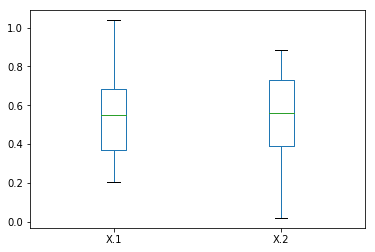

In [5]:
TwoDim.drop(columns = ['ID', 'cluster']).plot(kind = 'box')

## Sample Output

In [6]:
KMeansFormal(4, Two).head()

,Cluster,RowID
0,2,0
1,2,1
2,2,2
3,2,3
4,2,4


## True Cluster Membership

SSB : 95.400839
SSE : 39.600296
Cluster-wise SSE:
Cluster 1: 4.500000
Cluster 2: 8.410000
Cluster 3: 13.730000
Cluster 4: 12.950000


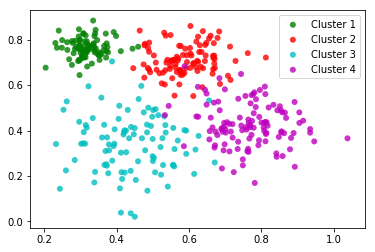

In [8]:
groups = TwoDim.groupby('cluster')
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) 
for name, group in groups:
    ax.scatter(group['X.1'], group['X.2'],alpha=0.8, c=colors[name], edgecolors='none', label='Cluster '+str(name))
ax.legend()


#printmd('## True Cluster Membership')
SSE, SSB, SSE_cluster = calculateMeasures(Two, TwoDim.cluster.values, updateCentroids(Two, TwoDim.cluster.values, np.zeros((4,Two.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))
    
plt.show()

## K = 4

In [9]:
# Random Centroids
SSE, SSB = [], []
for i in range(100):
    centroids, iterations, clusters = KMeans(4, Two)
    t1, t2, _ = calculateMeasures(Two, clusters, centroids)
    SSE.append(t1)
    SSB.append(t2)
    
print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

x = round(pd.DataFrame({'SSE' : SSE, 'SSB' : SSB}),2)
display(pd.Series(x.SSE.astype(str) + ' | ' + x.SSB.astype(str)).value_counts())


Mean SSE : 40.554573 & Mean SSB : 95.114205


37.97 | 96.34    81
53.65 | 84.46     4
50.77 | 91.06     3
51.37 | 91.93     3
50.81 | 90.91     2
50.82 | 91.24     2
50.8 | 91.15      2
51.28 | 90.92     1
51.33 | 91.78     1
51.33 | 92.02     1
dtype: int64

## Clustering Plot k = 4

SSB : 96.336777
SSE : 37.971170
Cluster-wise SSE:
Cluster 1: 5.530000
Cluster 2: 11.770000
Cluster 3: 9.480000
Cluster 4: 11.190000

Iteration till convergence : 7


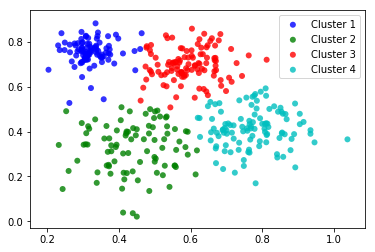

In [10]:
centroids, iterations, clusters = KMeans(4, Two)
#(TwoDim.cluster == clusters).value_counts()

labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)


printmd('## Clustering Plot k = 4')
SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

print('\nIteration till convergence : %d' %(iterations))
plt.show()

In [12]:
new_clusters = []
for i in clusters:
    if i == 1:
        new_clusters.append(1)
    elif i == 3:
        new_clusters.append(2)
    elif i == 2:
        new_clusters.append(3)
    elif i == 4:
        new_clusters.append(4)


display(pd.crosstab(pd.Series(new_clusters, name = 'Assigned Cluster'), pd.Series(TwoDim.cluster, name = 'True Clusters')))


True Clusters,1,2,3,4
Assigned Cluster,,,,
1,89,2,4,0
2,0,98,2,8
3,0,0,88,2
4,0,0,3,104


## K = 3

In [15]:
# Random Centroids
SSE, SSB = [], []
for i in range(100):
    centroids, iterations, clusters = KMeans(3, Two)
    t1, t2, _ = calculateMeasures(Two, clusters, centroids)
    SSE.append(t1)
    SSB.append(t2)
    
print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

x = round(pd.DataFrame({'SSE' : SSE, 'SSB' : SSB}),2)
display(pd.Series(x.SSE.astype(str) + ' | ' + x.SSB.astype(str)).value_counts())


Mean SSE : 54.052178 & Mean SSB : 88.794666


53.9 | 90.7      42
53.88 | 90.64    29
53.65 | 84.46    20
53.78 | 84.39     3
54.55 | 84.13     1
56.4 | 84.47      1
53.92 | 84.42     1
53.74 | 84.41     1
69.52 | 77.27     1
56.36 | 84.47     1
dtype: int64

## Clustering Plot k = 3

SSB : 90.636953
SSE : 53.881737
Cluster-wise SSE:
Cluster 1: 12.220000
Cluster 2: 13.810000
Cluster 3: 27.850000

Iteration till convergence : 7


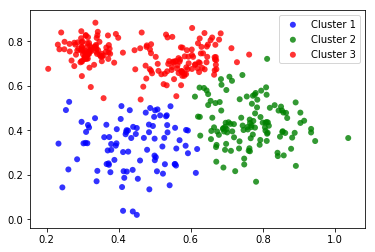

In [18]:
centroids, iterations, clusters = KMeans(3, Two)
#(TwoDim.cluster == clusters).value_counts()

labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)


printmd('## Clustering Plot k = 3')
SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

print('\nIteration till convergence : %d' %(iterations))
plt.show()

In [20]:
new_clusters = []
for i in clusters:
    if i == 3:
        new_clusters.append(1)
    elif i == 1:
        new_clusters.append(3)
    elif i == 2:
        new_clusters.append(4)
    elif i == 4:
        new_clusters.append(4)


display(pd.crosstab(pd.Series(new_clusters, name = 'Assigned Cluster'), pd.Series(TwoDim.cluster, name = 'True Clusters')))


True Clusters,1,2,3,4
Assigned Cluster,,,,
1,89,94,5,1
3,0,0,89,3
4,0,6,3,110


In [21]:
# Sampling Centroids
SSE, SSB = [], []
for i in range(100):
    cent = reallyreallyInitializeCentroids(Two, 4)
    centroids, iterations, clusters = KMeans(4, Two, cent)
    t1, t2, _ = calculateMeasures(Two, clusters, centroids)
    SSE.append(t1)
    SSB.append(t2)
    
print('Mean SSE : %f & Mean SSB : %f' % (np.mean(SSE), np.mean(SSB)))

Mean SSE : 42.209433 & Mean SSB : 94.633792


## Clustering Plot

SSB : 96.336777
SSE : 37.971170
Cluster-wise SSE:
Cluster 1: 11.770000
Cluster 2: 5.530000
Cluster 3: 11.190000
Cluster 4: 9.480000


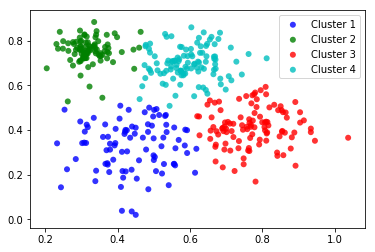

In [22]:
cent = reallyreallyInitializeCentroids(Two, 4)
centroids, iterations, clusters = KMeans(4, Two, cent)
#(TwoDim.cluster == clusters).value_counts()

labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(clusters), colors, labels):
    x = Two[np.where(clusters == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.legend(loc=1)


printmd('## Clustering Plot')
SSE, SSB, SSE_cluster = calculateMeasures(Two, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))


plt.show()

## Ideal K Value

In [24]:
SSE_per_k = []
for j in range(1,11):
    #print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        centroids, iterations, clusters = KMeans(j, Two)
        t1, t2, _ = calculateMeasures(Two, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k.append(np.mean(SSE))

Text(0,0.5,'SSE')

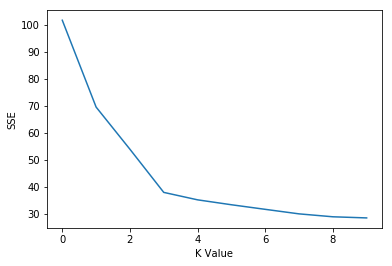

In [25]:
#SSE_per_k
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

# Dataset 2 : Wine Data Clustering

In [26]:
# Data Load
wine = pd.read_csv('winequality-red.csv', sep = ';')
Wine_Base = np.array(wine.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide']))


scaler = preprocessing.MinMaxScaler()
scaler.fit(Wine_Base)
Wine_Norm = scaler.transform(Wine_Base)
Wine_Softmax = softmax(Wine_Base)

In [27]:
wine.quality.value_counts()


5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

## Non normalized data

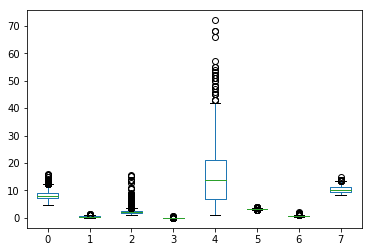

In [28]:
pd.DataFrame(Wine_Base).plot(kind = 'box')

In [32]:
centroids, iterations, clusters = KMeans(10, Wine_Base)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
#for i,x in enumerate(SSE_cluster):
    #print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 8
8    1160
2     439
dtype: int64


SSB : 12259.873723
SSE : 8675.620093
Cluster-wise SSE:


In [33]:
k = 10
cent = reallyreallyInitializeCentroids(Wine_Base, k)
centroids, iterations, clusters = KMeans(k, Wine_Base, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
#for i,x in enumerate(SSE_cluster):
    #print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 24
1     522
10    396
5     277
4     196
3     110
7      65
9      19
6       6
8       4
2       4
dtype: int64


SSB : 13143.136139
SSE : 4355.418785
Cluster-wise SSE:


# Sampling with Conditions

In [35]:
SSE_per_k_Base = []
for j in range(3,20):
    #print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        cent = reallyreallyInitializeCentroids(Wine_Base, j)
        centroids, iterations, clusters = KMeans(j, Wine_Base, cent)
        t1, t2, _ = calculateMeasures(Wine_Base, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Base.append(np.mean(SSE))

Text(0,0.5,'SSE')

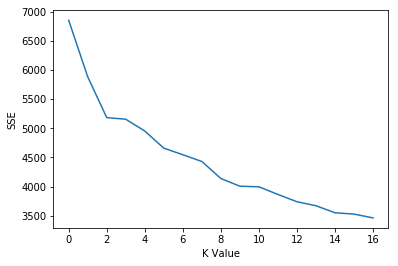

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Base, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

## Random Sampling

Text(0,0.5,'SSE')

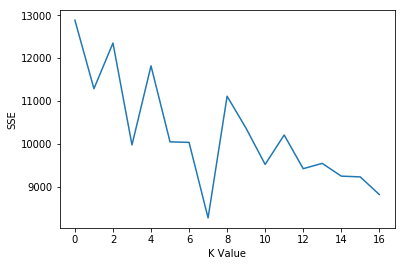

In [38]:
SSE_per_k_Base_Rand = []
for j in range(3,20):
    #print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        centroids, iterations, clusters = KMeans(j, Wine_Base)
        t1, t2, _ = calculateMeasures(Wine_Base, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Base_Rand.append(np.mean(SSE))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Base_Rand, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

Text(0,0.5,'SSE')

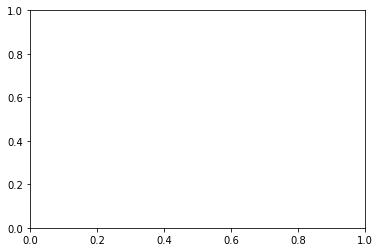

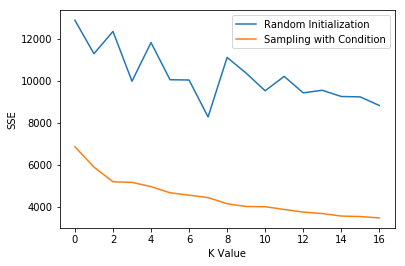

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.DataFrame({'Sampling with Condition': SSE_per_k_Base, 'Random Initialization' : SSE_per_k_Base_Rand}).plot()
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

# Min-Max Normalizaed

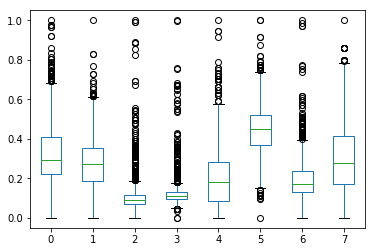

In [40]:
pd.DataFrame(Wine_Norm).plot(kind = 'box')

In [41]:
centroids, iterations, clusters = KMeans(10, Wine_Norm)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 17
1    581
8    292
7    256
3    233
5    208
9     29
dtype: int64


SSB : 377.185081
SSE : 374.277998
Cluster-wise SSE:
Cluster 1: 112.860000
Cluster 2: 0.000000
Cluster 3: 56.750000
Cluster 4: 0.000000
Cluster 5: 52.890000
Cluster 6: 0.000000
Cluster 7: 60.020000
Cluster 8: 82.430000
Cluster 9: 9.330000
Cluster 10: 0.000000


In [42]:
k = 10
cent = reallyreallyInitializeCentroids(Wine_Norm, k)
centroids, iterations, clusters = KMeans(k, Wine_Norm, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 13
7     502
4     270
8     238
6     218
5     164
3     128
1      34
9      23
2      21
10      1
dtype: int64


SSB : 396.028296
SSE : 355.047248
Cluster-wise SSE:
Cluster 1: 13.850000
Cluster 2: 6.540000
Cluster 3: 29.230000
Cluster 4: 63.940000
Cluster 5: 39.070000
Cluster 6: 50.810000
Cluster 7: 92.250000
Cluster 8: 54.320000
Cluster 9: 5.040000
Cluster 10: 0.000000


In [43]:
SSE_per_k_Norm = []
for j in range(3,20):
    #print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        cent = reallyreallyInitializeCentroids(Wine_Norm, j)
        centroids, iterations, clusters = KMeans(j, Wine_Norm, cent)
        t1, t2, _ = calculateMeasures(Wine_Norm, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Norm.append(np.mean(SSE))

Text(0,0.5,'SSE')

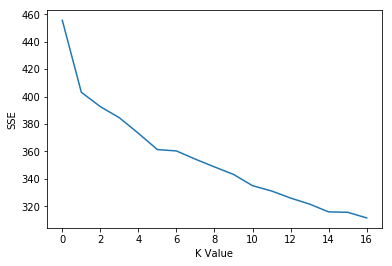

In [44]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Norm, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

# Softmax Normalizaed

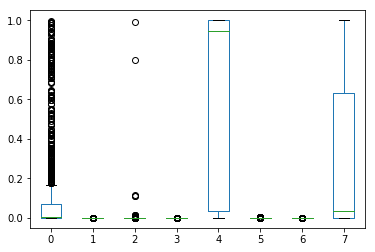

In [45]:
pd.DataFrame(Wine_Softmax).plot(kind = 'box')

In [46]:
centroids, iterations, clusters = KMeans(10, Wine_Softmax)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 13
7     924
10    347
9     125
1     107
3      96
dtype: int64


SSB : 901.204779
SSE : 132.682162
Cluster-wise SSE:
Cluster 1: 14.710000
Cluster 2: 0.000000
Cluster 3: 14.450000
Cluster 4: 0.000000
Cluster 5: 0.000000
Cluster 6: 0.000000
Cluster 7: 40.120000
Cluster 8: 0.000000
Cluster 9: 25.730000
Cluster 10: 37.670000


In [47]:
k = 10
cent = reallyreallyInitializeCentroids(Wine_Softmax, k)
centroids, iterations, clusters = KMeans(k, Wine_Softmax, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

print('\n')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 24
4     850
1     278
8     106
7      89
10     78
6      72
9      67
5      46
3      11
2       2
dtype: int64


SSB : 909.010465
SSE : 86.849083
Cluster-wise SSE:
Cluster 1: 20.530000
Cluster 2: 0.270000
Cluster 3: 1.430000
Cluster 4: 14.510000
Cluster 5: 5.340000
Cluster 6: 8.630000
Cluster 7: 7.950000
Cluster 8: 11.270000
Cluster 9: 6.620000
Cluster 10: 10.310000


In [49]:
SSE_per_k_Soft = []
for j in range(3,20):
    #print('Calculating for k : %d' % (j))
    SSE, SSB = [], []
    for i in range(10):
        cent = reallyreallyInitializeCentroids(Wine_Softmax, j)
        centroids, iterations, clusters = KMeans(j, Wine_Softmax, cent)
        t1, t2, _ = calculateMeasures(Wine_Softmax, clusters, centroids)
        SSE.append(t1)
        SSB.append(t2)
    SSE_per_k_Soft.append(np.mean(SSE))

Text(0,0.5,'SSE')

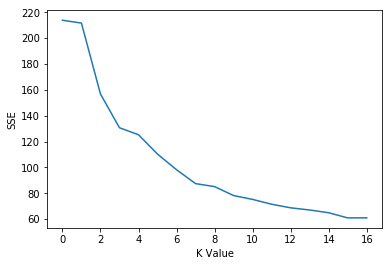

In [50]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = pd.Series(SSE_per_k_Soft, name = 'SSE').plot(kind = 'line')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

Text(0,0.5,'SSE')

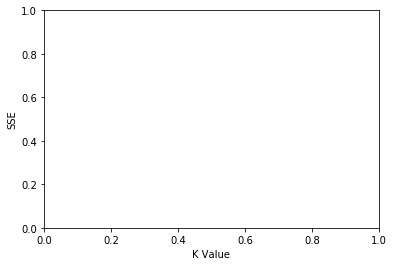

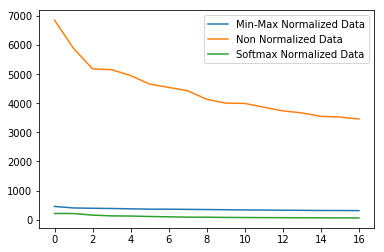

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
pd.DataFrame({'Non Normalized Data' : SSE_per_k_Base, 'Min-Max Normalized Data': SSE_per_k_Norm, 'Softmax Normalized Data' : SSE_per_k_Soft}).plot()
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

<IPython.core.display.Javascript object>


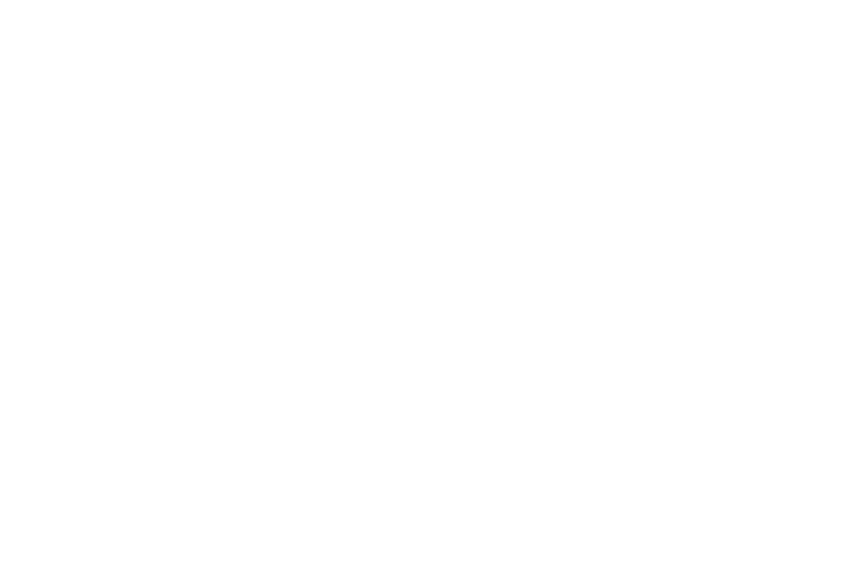

<IPython.core.display.Javascript object>


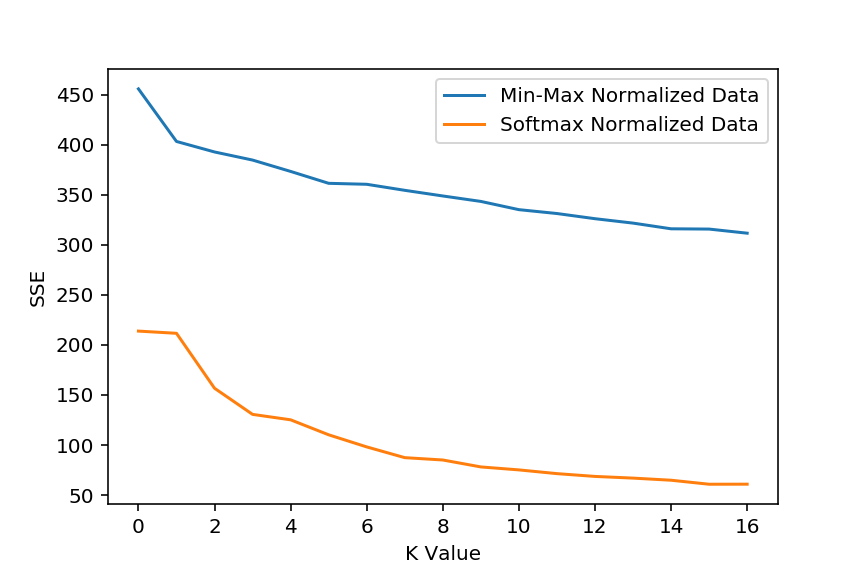

In [54]:
%matplotlib notebook
fig = plt.figure()
ax = pd.DataFrame({'Min-Max Normalized Data': SSE_per_k_Norm, 'Softmax Normalized Data' : SSE_per_k_Soft}).plot()
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')
fig.show()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15, 6))

ax = pd.Series(SSE_per_k_Soft, name = 'SSE').plot(kind = 'line', ax =  axs[2], title =  'Base Data')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')
ax = pd.Series(SSE_per_k_Norm, name = 'SSE').plot(kind = 'line', ax =  axs[1], title =  'Min-Max Normalized Dataset')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')
ax = pd.Series(SSE_per_k_Base, name = 'SSE').plot(kind = 'line', ax =  axs[0], title =  'Softmax Normalized Dataset')
ax.set_xlabel('K Value')
ax.set_ylabel('SSE')

# Comparing with quality 

In [55]:
printmd('## Quality as Cluster Membership')
k =10

printmd('### Softmax')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, wine.quality.values, updateCentroids(Wine_Softmax, wine.quality.values, np.zeros((k,Wine_Softmax.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))
    
    
printmd('### Base')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, wine.quality.values, updateCentroids(Wine_Base, wine.quality.values, np.zeros((k,Wine_Base.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))
    
printmd('### Min-Max')
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, wine.quality.values, updateCentroids(Wine_Norm, wine.quality.values, np.zeros((k,Wine_Norm.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

## Quality as Cluster Membership

### Softmax

SSB : 117.726085
SSE : 893.488849
Cluster-wise SSE:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 7.040000
Cluster 4: 32.680000
Cluster 5: 354.530000
Cluster 6: 365.690000
Cluster 7: 121.720000
Cluster 8: 11.830000
Cluster 9: 0.000000
Cluster 10: 0.000000


### Base

SSB : 1752.400006
SSE : 13757.663654
Cluster-wise SSE:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 79.470000
Cluster 4: 396.970000
Cluster 5: 6143.840000
Cluster 6: 5308.000000
Cluster 7: 1664.830000
Cluster 8: 164.560000
Cluster 9: 0.000000
Cluster 10: 0.000000


### Min-Max

SSB : 144.373660
SSE : 496.197060
Cluster-wise SSE:
Cluster 1: 0.000000
Cluster 2: 0.000000
Cluster 3: 3.510000
Cluster 4: 17.630000
Cluster 5: 202.140000
Cluster 6: 204.340000
Cluster 7: 62.520000
Cluster 8: 6.060000
Cluster 9: 0.000000
Cluster 10: 0.000000


In [56]:
k = 6
cent = reallyreallyInitializeCentroids(Wine_Norm, k)
centroids, iterations, clusters = KMeans(k, Wine_Norm, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

Number of iterations : 18
1    603
6    332
4    304
5    296
2     35
3     29
dtype: int64
SSB : 368.044307
SSE : 383.988652
Cluster-wise SSE:
Cluster 1: 124.490000
Cluster 2: 14.230000
Cluster 3: 9.330000
Cluster 4: 74.290000
Cluster 5: 76.620000
Cluster 6: 85.030000


In [57]:
wine_eda = wine.copy()
wine_eda['cal_qual'] = clusters
wine_eda.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide'], inplace = True)
wine_eda.groupby('cal_qual').mean()


,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,pH,sulphates,alcohol
cal_qual,,,,,,,,
1,7.626368,0.623914,2.259453,0.085557,11.435323,3.352637,0.596070,9.818905
2,8.171429,0.538143,9.322857,0.103229,35.542857,3.260286,0.648286,9.977143
3,8.327586,0.534828,1.982759,0.341172,16.172414,3.038276,1.320000,9.448276
4,8.007895,0.514523,2.391283,0.081957,30.475329,3.323980,0.656546,10.093969
5,7.211824,0.472196,2.379730,0.071686,13.949324,3.414662,0.666858,11.912556
6,10.866867,0.413358,2.656476,0.086226,10.186747,3.160783,0.707831,10.625502


In [58]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [59]:
def smaller():
    Wine_Base = np.array(wine.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide','pH', 'volatile acidity']))
    print(Wine_Base.shape)
    scaler1 = preprocessing.MinMaxScaler()
    scaler1.fit(Wine_Base)
    Wine_Norm = scaler1.transform(Wine_Base)

    k = 6
    cent = reallyreallyInitializeCentroids(Wine_Norm, k)
    centroids, iterations, clusters = KMeans(k, Wine_Norm, cent)
    print('Number of iterations : %d' % (iterations))
    print(pd.Series(clusters).value_counts())

    SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
    print('SSB : %f' % (SSB))
    print('SSE : %f' % (SSE))
    print('Cluster-wise SSE:')
    for i,x in enumerate(SSE_cluster):
        print('Cluster %d: %f' %(i+1, round(x,2)))

    wine_eda = wine.copy()
    wine_eda['Cluster'] = clusters
    wine_eda.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide'], inplace = True)
    display(wine_eda.groupby('Cluster').mean())

smaller()

(1599, 6)
Number of iterations : 13
2    610
6    353
5    269
3    269
4     74
1     24
dtype: int64
SSB : 341.018813
SSE : 308.891860
Cluster-wise SSE:
Cluster 1: 4.930000
Cluster 2: 88.780000
Cluster 3: 63.820000
Cluster 4: 17.610000
Cluster 5: 60.670000
Cluster 6: 73.090000


,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,pH,sulphates,alcohol
Cluster,,,,,,,,
1,8.441667,0.523542,1.987500,0.399667,15.041667,3.064583,1.190417,9.420833
2,7.706557,0.593377,2.206721,0.085343,12.274590,3.343836,0.590164,9.727541
3,7.954647,0.530037,3.119517,0.085409,33.258364,3.322268,0.636022,10.125898
4,8.989189,0.444392,2.283784,0.085730,15.000000,3.225946,1.044595,10.227027
5,11.164312,0.434182,2.867472,0.086275,10.379182,3.158253,0.688364,10.603965
6,7.340793,0.501983,2.510623,0.072751,13.277620,3.397167,0.652266,11.822427


In [60]:
# Wine_Base = np.array(wine.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide','pH', 'volatile acidity']))
# Wine_Norm = scaler.transform(Wine_Base)

k = 6
cent = reallyreallyInitializeCentroids(Wine_Norm, k)
centroids, iterations, clusters = KMeans(k, Wine_Norm, cent)
print('Number of iterations : %d' % (iterations))
print(pd.Series(clusters).value_counts())

SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, clusters, centroids)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

wine_eda = wine.copy()
wine_eda['cal_qual'] = clusters
wine_eda.drop(columns = ['quality','citric acid','density' ,'total sulfur dioxide'], inplace = True)
display(wine_eda.groupby('cal_qual').mean())

Number of iterations : 22
5    525
1    290
3    281
2    259
4    209
6     35
dtype: int64
SSB : 371.667463
SSE : 386.166297
Cluster-wise SSE:
Cluster 1: 70.280000
Cluster 2: 65.070000
Cluster 3: 72.400000
Cluster 4: 58.970000
Cluster 5: 105.210000
Cluster 6: 14.230000


,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,pH,sulphates,alcohol
cal_qual,,,,,,,,
1,7.958966,0.515828,2.395345,0.081062,30.787931,3.321759,0.652414,10.103333
2,11.040541,0.399266,2.773166,0.082768,10.505792,3.162741,0.718880,10.951609
3,7.169751,0.471210,2.363345,0.071409,14.120996,3.416050,0.664804,11.937782
4,9.191388,0.491699,2.157895,0.131813,11.344498,3.176124,0.773062,9.621053
5,7.454857,0.641857,2.295714,0.083211,11.717143,3.379390,0.582705,9.876952
6,8.171429,0.538143,9.322857,0.103229,35.542857,3.260286,0.648286,9.977143


<IPython.core.display.Javascript object>


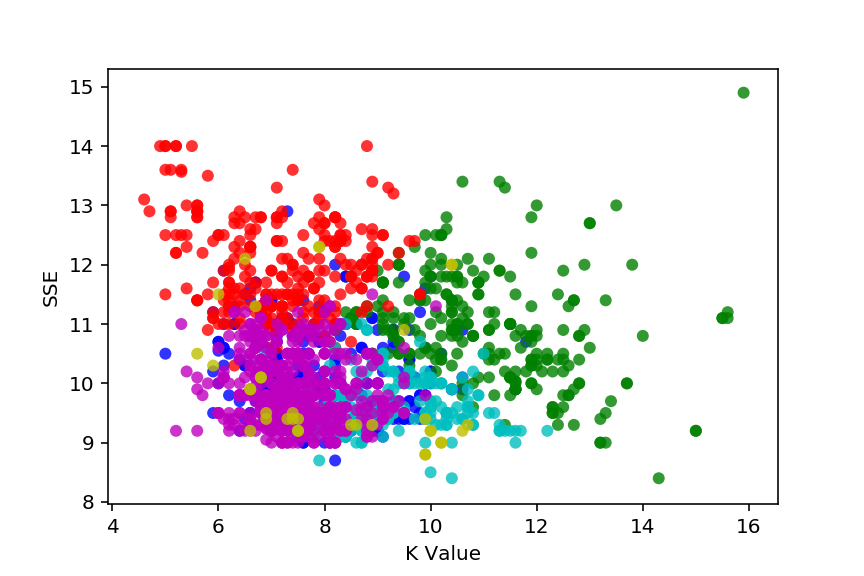

1 b Cluster 1
2 g Cluster 2
3 r Cluster 3
4 c Cluster 4
5 m Cluster 5
6 y Cluster 6


In [61]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
labels = ['Cluster ' + str(i) for i in np.unique(clusters)]
for data, color, group in zip(np.unique(clusters), colors, labels):
    print(data, color, group)
    x = wine_eda['fixed acidity'][np.where(clusters == data)[0]]
    y = wine_eda['alcohol'][np.where(clusters == data)[0]]
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group) 
    ax.set_xlabel('K Value')
    ax.set_ylabel('SSE')

plt.show()
#plt.legend(loc=1)

<IPython.core.display.Javascript object>


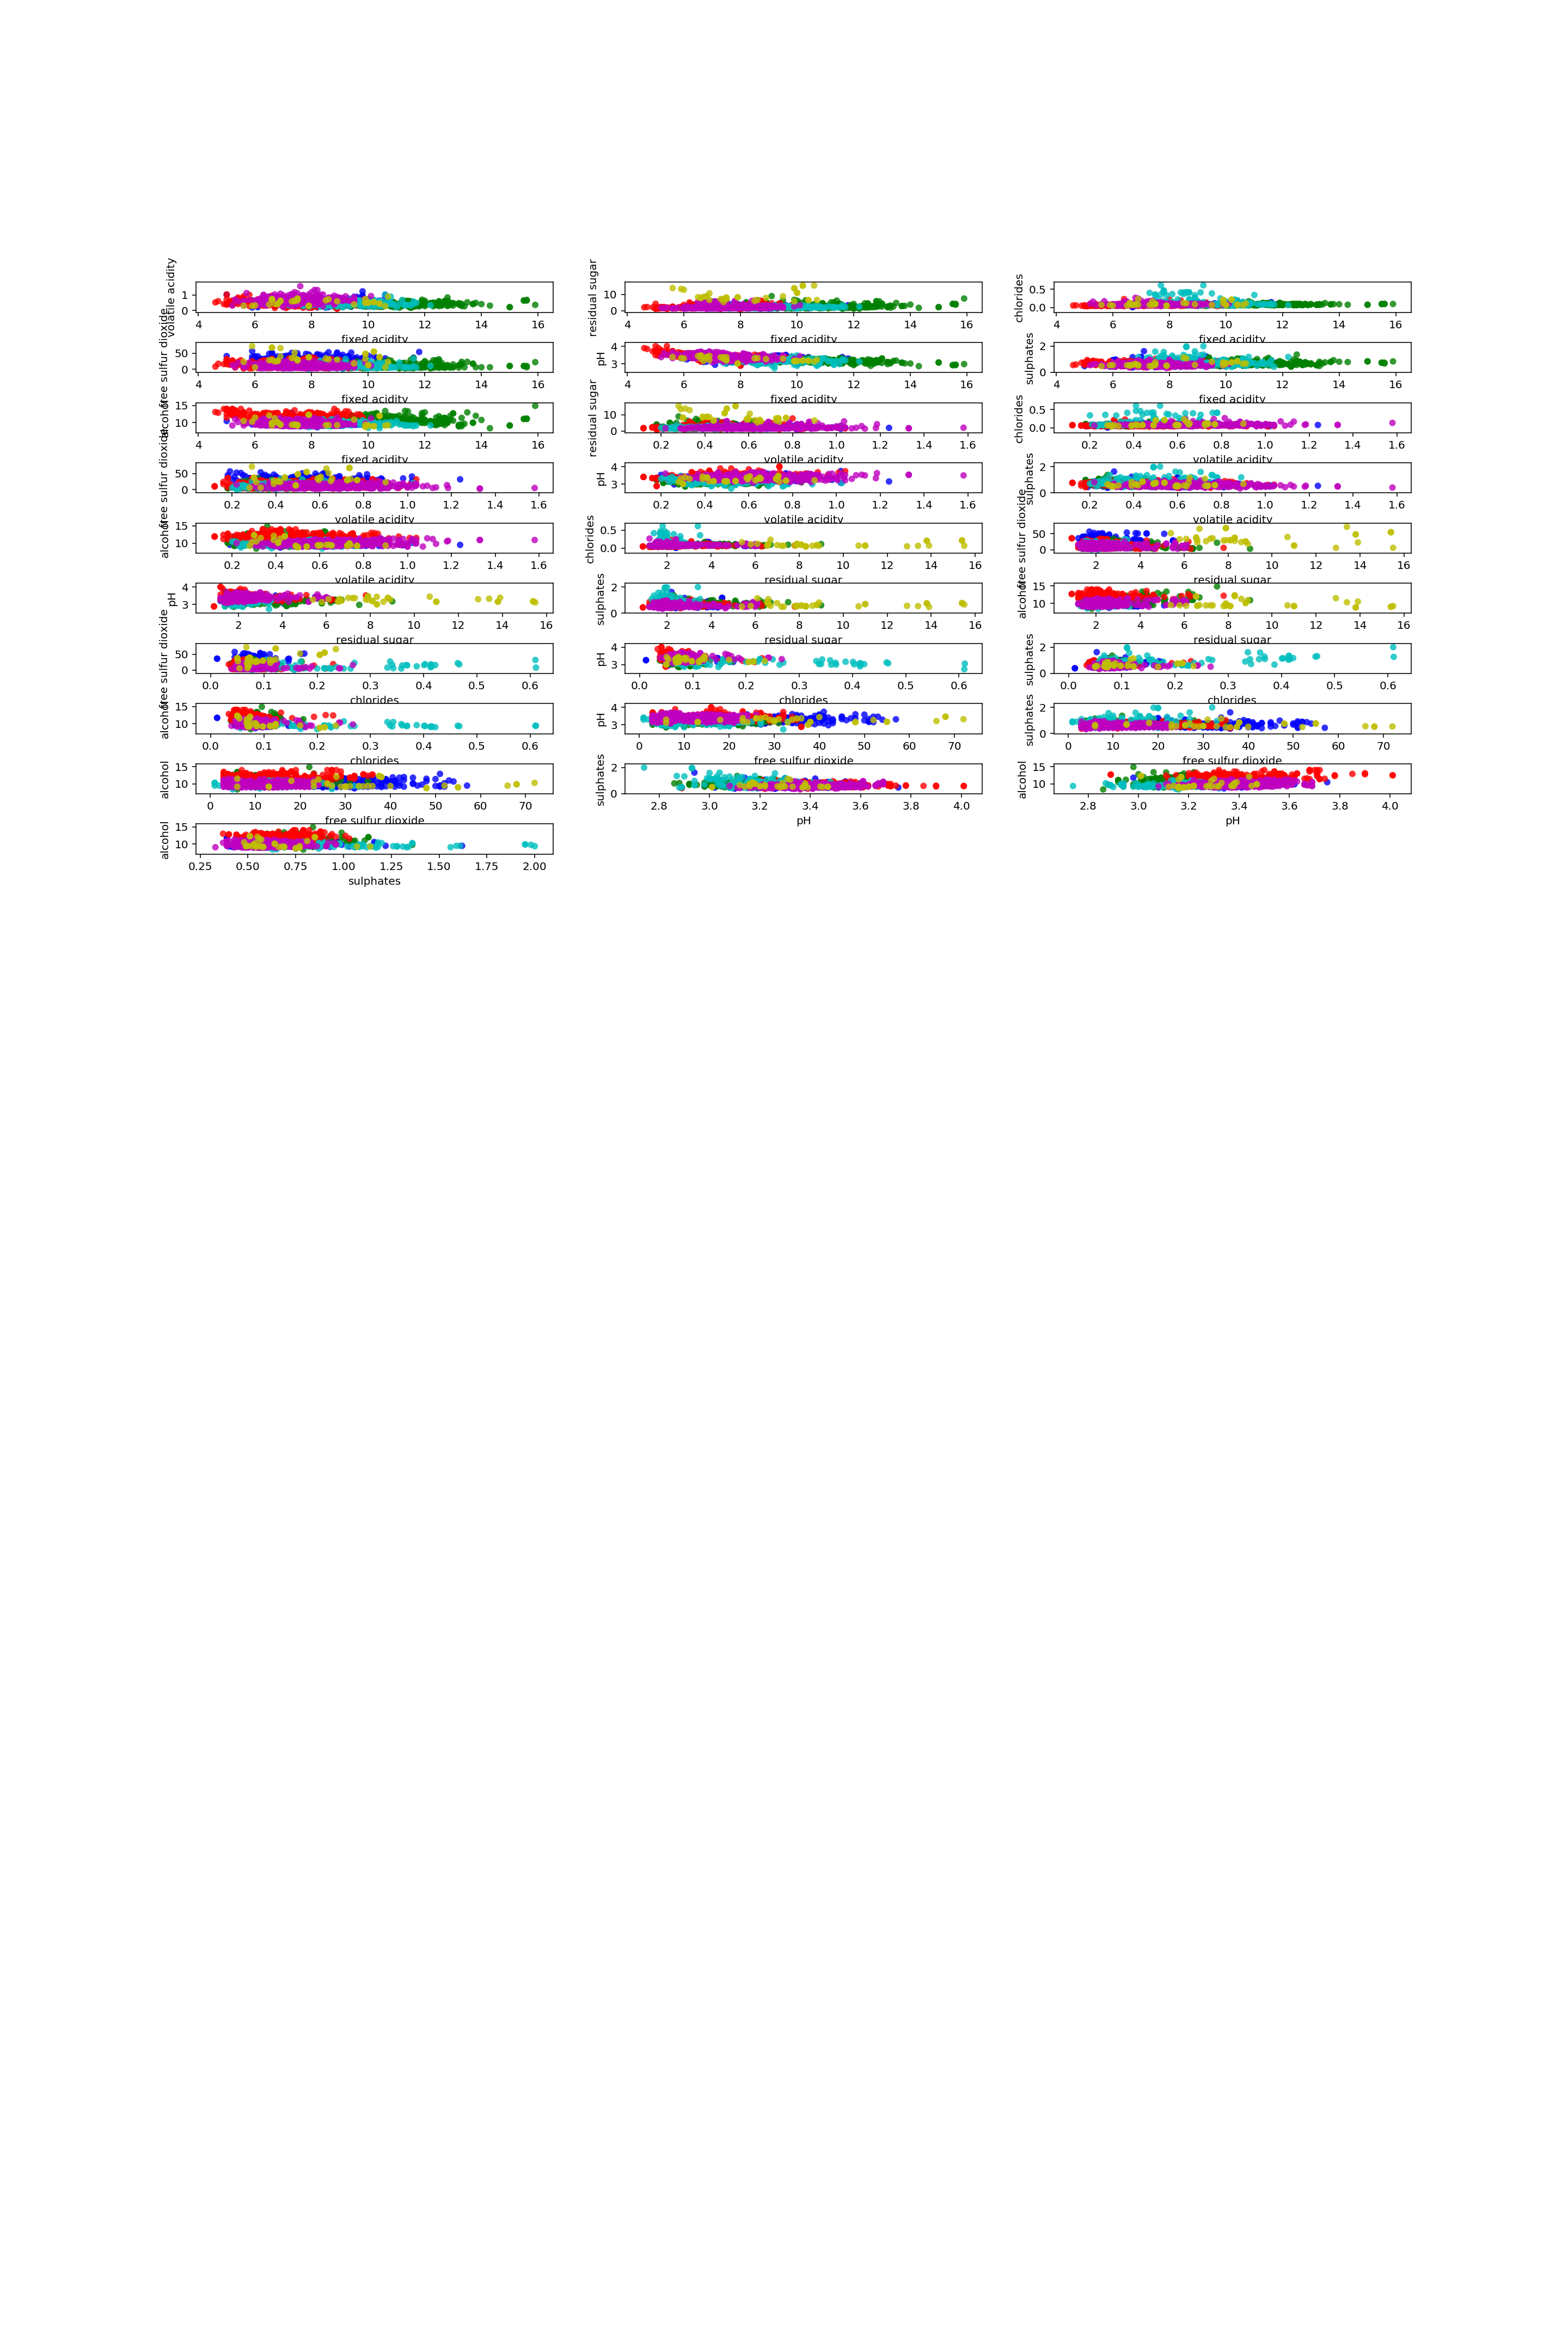

In [62]:
%matplotlib notebook

columns_list = []
for i in range(8):
    for j in range(i+1,8):
        #print(i,j)
        columns_list.append((wine_eda.columns[i], wine_eda.columns[j]))

plt.figure(figsize = (20, 30)).subplots_adjust(hspace=1)
counter = 0
for i,j in columns_list:
    counter += 1
    plt.subplot(30,3, counter)
    for data, color, group in zip(np.unique(clusters), colors, labels):
            x = wine_eda[i][np.where(clusters == data)[0]]
            y = wine_eda[j][np.where(clusters == data)[0]]
            plt.scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group)
            plt.xlabel(i)
            plt.ylabel(j)

        
plt.show()



In [ ]:
['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides','free sulfur dioxide', 'pH', 'sulphates', 'alcohol', 'cal_qual']

<IPython.core.display.Javascript object>


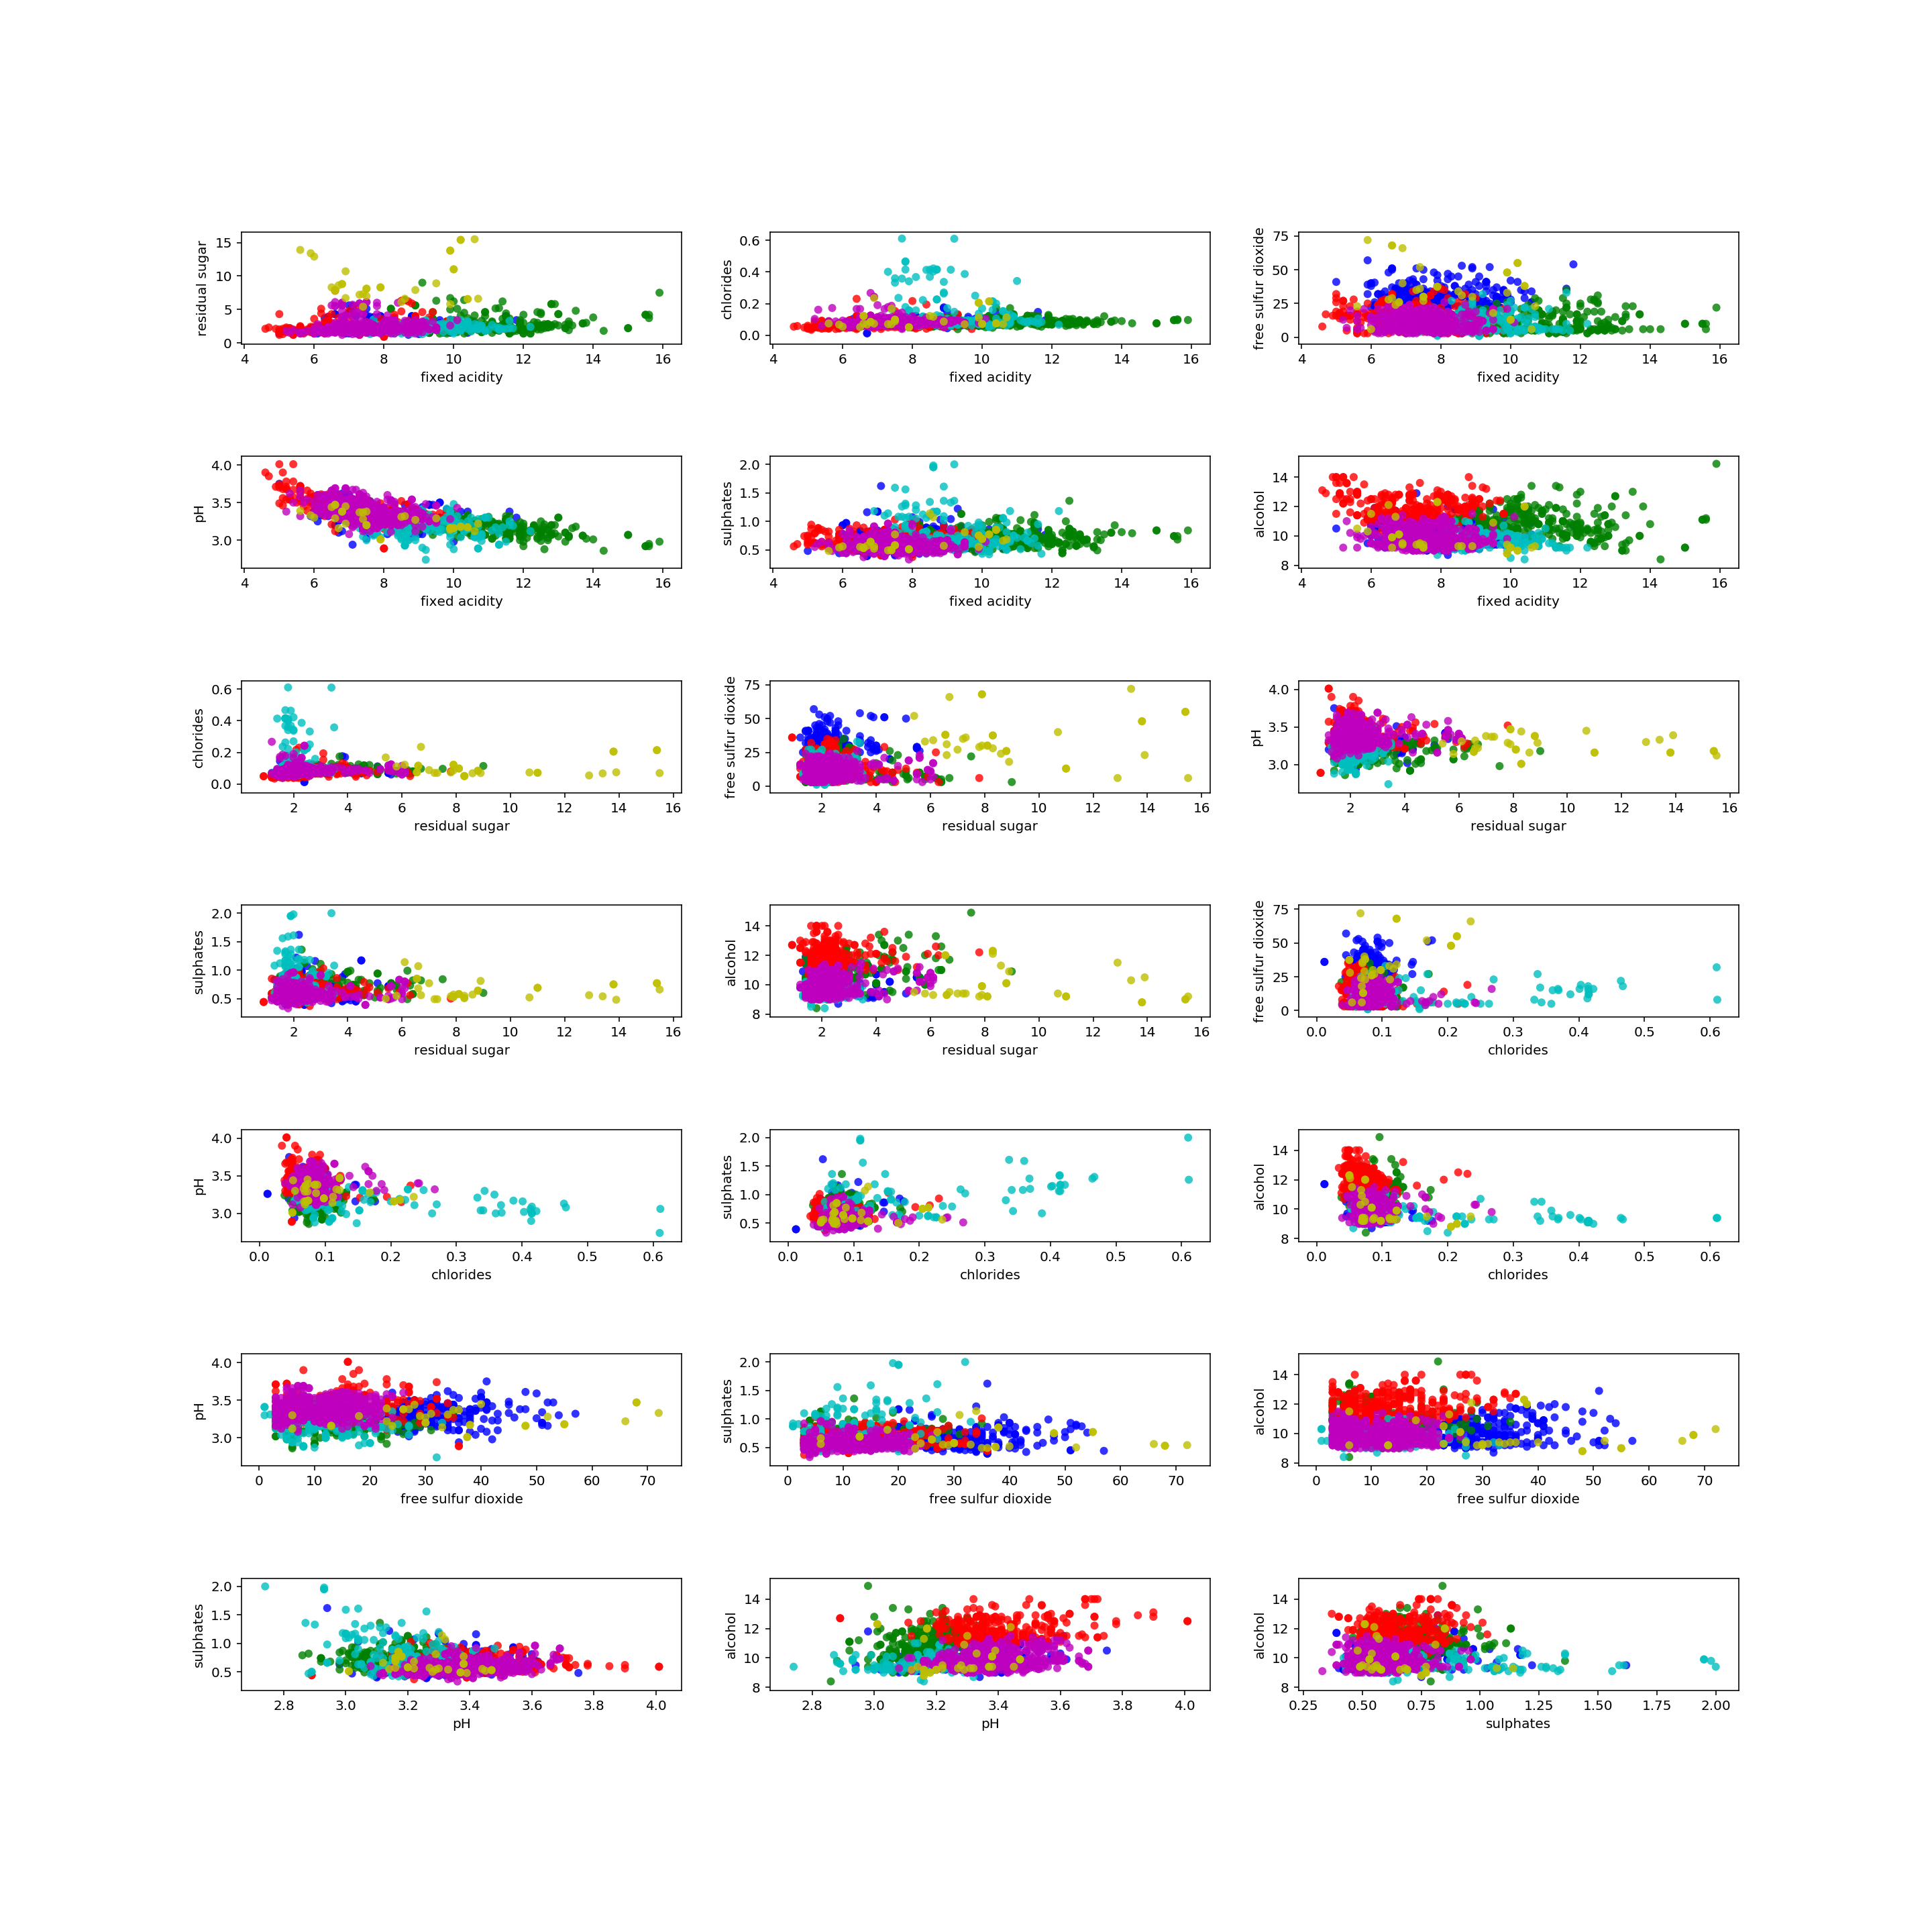

In [63]:
%matplotlib notebook

cols_of_interest = ['fixed acidity','residual sugar', 'chlorides','free sulfur dioxide', 'pH', 'sulphates', 'alcohol']
columns_list = []
for i in range(8):
    for j in range(i+1,len(cols_of_interest)):
        #print(i,j)
        columns_list.append((cols_of_interest[i], cols_of_interest[j]))

#f = plt.figure(figsize = (20, 30)).subplots_adjust(hspace=1)
fig, axes = plt.subplots(7, 3, figsize=(20, 20))
fig.subplots_adjust(hspace=1)
#fig, ax = plt.subplots()
counter = -1
for i,j in columns_list:
    counter += 1
    for data, color, group in zip(np.unique(clusters), colors, labels):
            x = wine_eda[i][np.where(clusters == data)[0]]
            y = wine_eda[j][np.where(clusters == data)[0]]
            axes[int(counter/3),int(counter%3)].scatter(x, y, alpha=0.8, c=color, edgecolors='none', label=group)
            axes[int(counter/3),int(counter%3)].set_xlabel(i)
            axes[int(counter/3),int(counter%3)].set_ylabel(j)
            #ax.plot()


        
plt.show()


## Off the Shelf

In [64]:

KMS = KMeansPack(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Two)
print(KMS)
SSE, SSB, SSE_cluster = calculateMeasures(Two, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))
print('Cluster-wise SSE:')
for i,x in enumerate(SSE_cluster):
    print('Cluster %d: %f' %(i+1, round(x,2)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
SSB : 69.201623
SSE : 132.050176
Cluster-wise SSE:
Cluster 1: 37.040000
Cluster 2: 54.060000
Cluster 3: 40.950000
Cluster 4: 0.000000


0 b
1 g
2 r
3 c


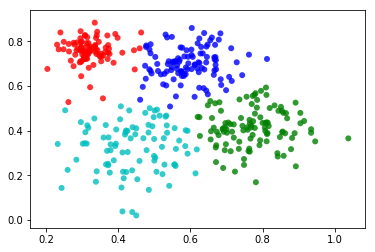

True Clusters,1,2,3,4
Assigned Cluster,,,,
1,0,0,88,2
2,0,0,3,104
3,0,98,2,8
4,89,2,4,0


In [65]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for data, color, group in zip(np.unique(KMS.labels_), colors, labels):
    print(data, color)
    x = Two[np.where(KMS.labels_ == data)]
    ax.scatter(x[:, 0], x[:, 1], alpha=0.8, c=color, edgecolors='none', label=group)
plt.show()

new_clusters = []
for i in KMS.labels_:
    if i == 3:
        new_clusters.append(1)
    elif i == 1:
        new_clusters.append(2)
    elif i == 0:
        new_clusters.append(3)
    elif i == 2:
        new_clusters.append(4)


display(pd.crosstab(pd.Series(new_clusters, name = 'Assigned Cluster'), pd.Series(TwoDim.cluster, name = 'True Clusters')))


In [66]:

print('\nWine_Base')
KMS = KMeansPack(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Base)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Norm')
KMS = KMeansPack(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Norm)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Softmax')
KMS = KMeansPack(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Softmax)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

KMS


Wine_Base
SSB : 21918.254885
SSE : 22763.068309

Wine_Norm
SSB : 492.968494
SSE : 686.906917

Wine_Softmax
SSB : 920.227024
SSE : 1708.065005


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [67]:
k = 6
print('\nWine_Base')
KMS = AgglomerativeClustering(n_clusters=k).fit(Wine_Base)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, updateCentroids(Wine_Base, KMS.labels_, np.zeros((k,Wine_Base.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Norm')
KMS = AgglomerativeClustering(n_clusters=k).fit(Wine_Norm)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, KMS.labels_, updateCentroids(Wine_Norm, KMS.labels_, np.zeros((k,Wine_Norm.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Softmax')
KMS = AgglomerativeClustering(n_clusters=k).fit(Wine_Softmax)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, KMS.labels_, updateCentroids(Wine_Softmax, KMS.labels_, np.zeros((k,Wine_Softmax.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

KMS


Wine_Base
SSB : 9996.298281
SSE : 3894.626869

Wine_Norm
SSB : 295.051116
SSE : 321.810498

Wine_Softmax
SSB : 475.223781
SSE : 87.884104


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=6,
            pooling_func=<function mean at 0x10be86d90>)

In [68]:

print('\nWine_Base')
KMS = MiniBatchKMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Base)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Norm')
KMS = MiniBatchKMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Norm)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Norm, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Softmax')
KMS = MiniBatchKMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=0.0001).fit(Wine_Softmax)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Softmax, KMS.labels_, KMS.cluster_centers_)
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

KMS


Wine_Base
SSB : 20390.371473
SSE : 32222.178842

Wine_Norm
SSB : 466.068307
SSE : 714.097214

Wine_Softmax
SSB : 690.736289
SSE : 1473.613544


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=300, max_no_improvement=10, n_clusters=6,
        n_init=10, random_state=None, reassignment_ratio=0.01, tol=0.0001,
        verbose=0)

In [69]:

print('\nWine_Base')
KMS = Birch(n_clusters=6).fit(Wine_Base)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, updateCentroids(Wine_Base, KMS.labels_, np.zeros((k,Wine_Base.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Norm')
KMS = Birch(n_clusters=6).fit(Wine_Norm)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, updateCentroids(Wine_Base, KMS.labels_, np.zeros((k,Wine_Base.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

print('\nWine_Softmax')
KMS = Birch(n_clusters=6).fit(Wine_Softmax)
SSE, SSB, SSE_cluster = calculateMeasures(Wine_Base, KMS.labels_, updateCentroids(Wine_Base, KMS.labels_, np.zeros((k,Wine_Base.shape[1]))))
print('SSB : %f' % (SSB))
print('SSE : %f' % (SSE))

KMS


Wine_Base
SSB : 12010.374985
SSE : 4774.456123

Wine_Norm
SSB : 0.000000
SSE : 0.000000

Wine_Softmax
SSB : 5712.962204
SSE : 1988.160733


/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: UserWarning: Number of subclusters found (1) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters))
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cluster/birch.py:629: UserWarning: Number of subclusters found (2) by Birch is less than (6). Decrease the threshold.
  % (len(centroids), self.n_clusters))


Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=6,
   threshold=0.5)